# Project 5: Ballistic Vehicle Altimetry System Design
>**Date Created**: 8 April 2024<br>
>**Course**: AEM556 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
import scipy
from scipy.integrate import odeint
from scipy.linalg import cholesky
from scipy.stats import norm
from random import random
import os

plt.rcParams["text.usetex"] = False

plt.rcParams["legend.edgecolor"] = "black"

In [2]:
data = "altimeter_data.csv"
df = pd.read_csv(data, header=None, names=["t", "yk", "hk", "sk", "cbk"])

In [3]:
# Create symbolic representations of variables to compute jacobians using SymPy
h, s, d, delt, cb, rn, hr, hn, re, gn = sp.symbols(
    r"h s d \Delta{t} C_b \rho_0 h_\rho h_0 R_E g_0"
)

# A. Implement an extended Kalman filter (EKF) to estimate the vehicle states, $h$ and $s$, and the ballistic coefficient parameter, $C_b$.

### Dynamics Model

In [4]:
def propogate(x):
    """Function to propogate full nonlinear dynamics with euler (first order) integration"""
    dt = 0.5
    rho_0 = 0.0765
    g0 = 32.2
    h_rho = 30000
    Re = 20902260
    h = x[0]
    s = x[1]
    cb = x[2]

    hkp1 = h + dt * s
    skp1 = s + dt * (
        ((rho_0 * s**2) / (2 * cb) * np.exp(-h / h_rho))
        - (g0 * ((Re / (Re + h)) ** 2))
    )
    cbkp1 = cb
    return np.array([hkp1, skp1, cbkp1])

In [5]:
def jacobian_F(x):
    """Function that computes analytical jacobian of F at state x"""
    F_discrete_symbolic = sp.Matrix(
        [
            [h + delt * s],
            [
                s
                + (
                    delt
                    * (
                        ((rn * s**2) / (2 * cb) * sp.exp(-h / hr))
                        - (gn * ((re / (re + h)) ** 2))
                    )
                )
            ],
            [cb],
        ]
    )
    # Create map of symbols to constant values
    constants_mapper = dict(
        zip([delt, rn, gn, hr, re], [0.5, 0.0765, 32.2, 30000, 20902260])
    )

    # Compute symbolic Jacobian and substitute in constants
    F_jacobian_symbolic = F_discrete_symbolic.jacobian([h, s, cb]).subs(
        constants_mapper
    )

    x = (np.array(x)).flatten()
    h_in = x[0]
    s_in = x[1]
    cb_in = x[2]
    F_jacobian = F_jacobian_symbolic.subs({h: h_in, s: s_in, cb: cb_in})
    return np.array(F_jacobian).astype(np.float64)

### Measurement Model

In [6]:
def get_measurement(x):
    """Computes predicted measurement using nonlinear measurement model"""
    h_in = x[0]
    d = 100000
    out = np.sqrt(d**2 + h_in**2)
    return out

In [7]:
def jacobian_H(x):
    h_in = x[0]
    s_in = x[1]
    cb_in = x[2]
    measurement_function = sp.Matrix([sp.sqrt(d**2 + h**2)])
    jacobian_H = measurement_function.jacobian([h, s, cb]).subs(
        {h: h_in, s: s_in, d: 100000}
    )
    return np.array(jacobian_H).astype(np.float64).flatten()

### Filter Equations

In [8]:
def predict(x_in, P_in, Q):
    F_jacobian = jacobian_F(x_in)
    x_k_km1 = propogate(x_in)
    P_k_km1 = F_jacobian @ P_in @ F_jacobian.T + Q
    return x_k_km1, P_k_km1


def update(x_k_km1, P_k_km1, range_meas):
    predicted_meausurement = get_measurement(x_k_km1)
    y_tilde = predicted_meausurement - range_meas
    Hk = jacobian_H(x_k_km1)
    Sk = (Hk @ P_k_km1 @ Hk.T) + R
    Kk = (P_k_km1 @ Hk.T) / Sk
    x_k_k = x_k_km1 - np.dot(Kk, y_tilde)
    Krk = Kk.reshape(3, 1) @ R.reshape(1, 1) @ Kk.reshape(1, 3)
    imkh = np.eye(3) - (Kk.reshape(3, 1) @ Hk.reshape(1, 3))
    P_k_k = imkh @ P_k_km1 @ imkh.T
    return x_k_k, P_k_k

### Run Filter on Measurements

In [9]:
P0 = np.diag([100**2, 10**2, 1])
Q = np.diag([10**2, 10**2, 0.05**2])
R = np.array([100**2])
x0 = np.array([400000, -2000, 20])

n = len(df["yk"])
res = np.zeros((n, 3))
Pks = np.zeros((n, 3, 3))
measurements_vector = df["yk"].to_numpy()
for k in range(n):
    if k == 0:
        x = x0
        P = P0
        res[k] = x
        Pks[k] = P
        continue
    x_k_k1, P_k_k1 = predict(x, P, Q)
    x_k_k, P_k_k = update(x_k_k1, P_k_k1, measurements_vector[k])
    x = x_k_k
    P = P_k_k
    res[k] = x
    Pks[k] = P

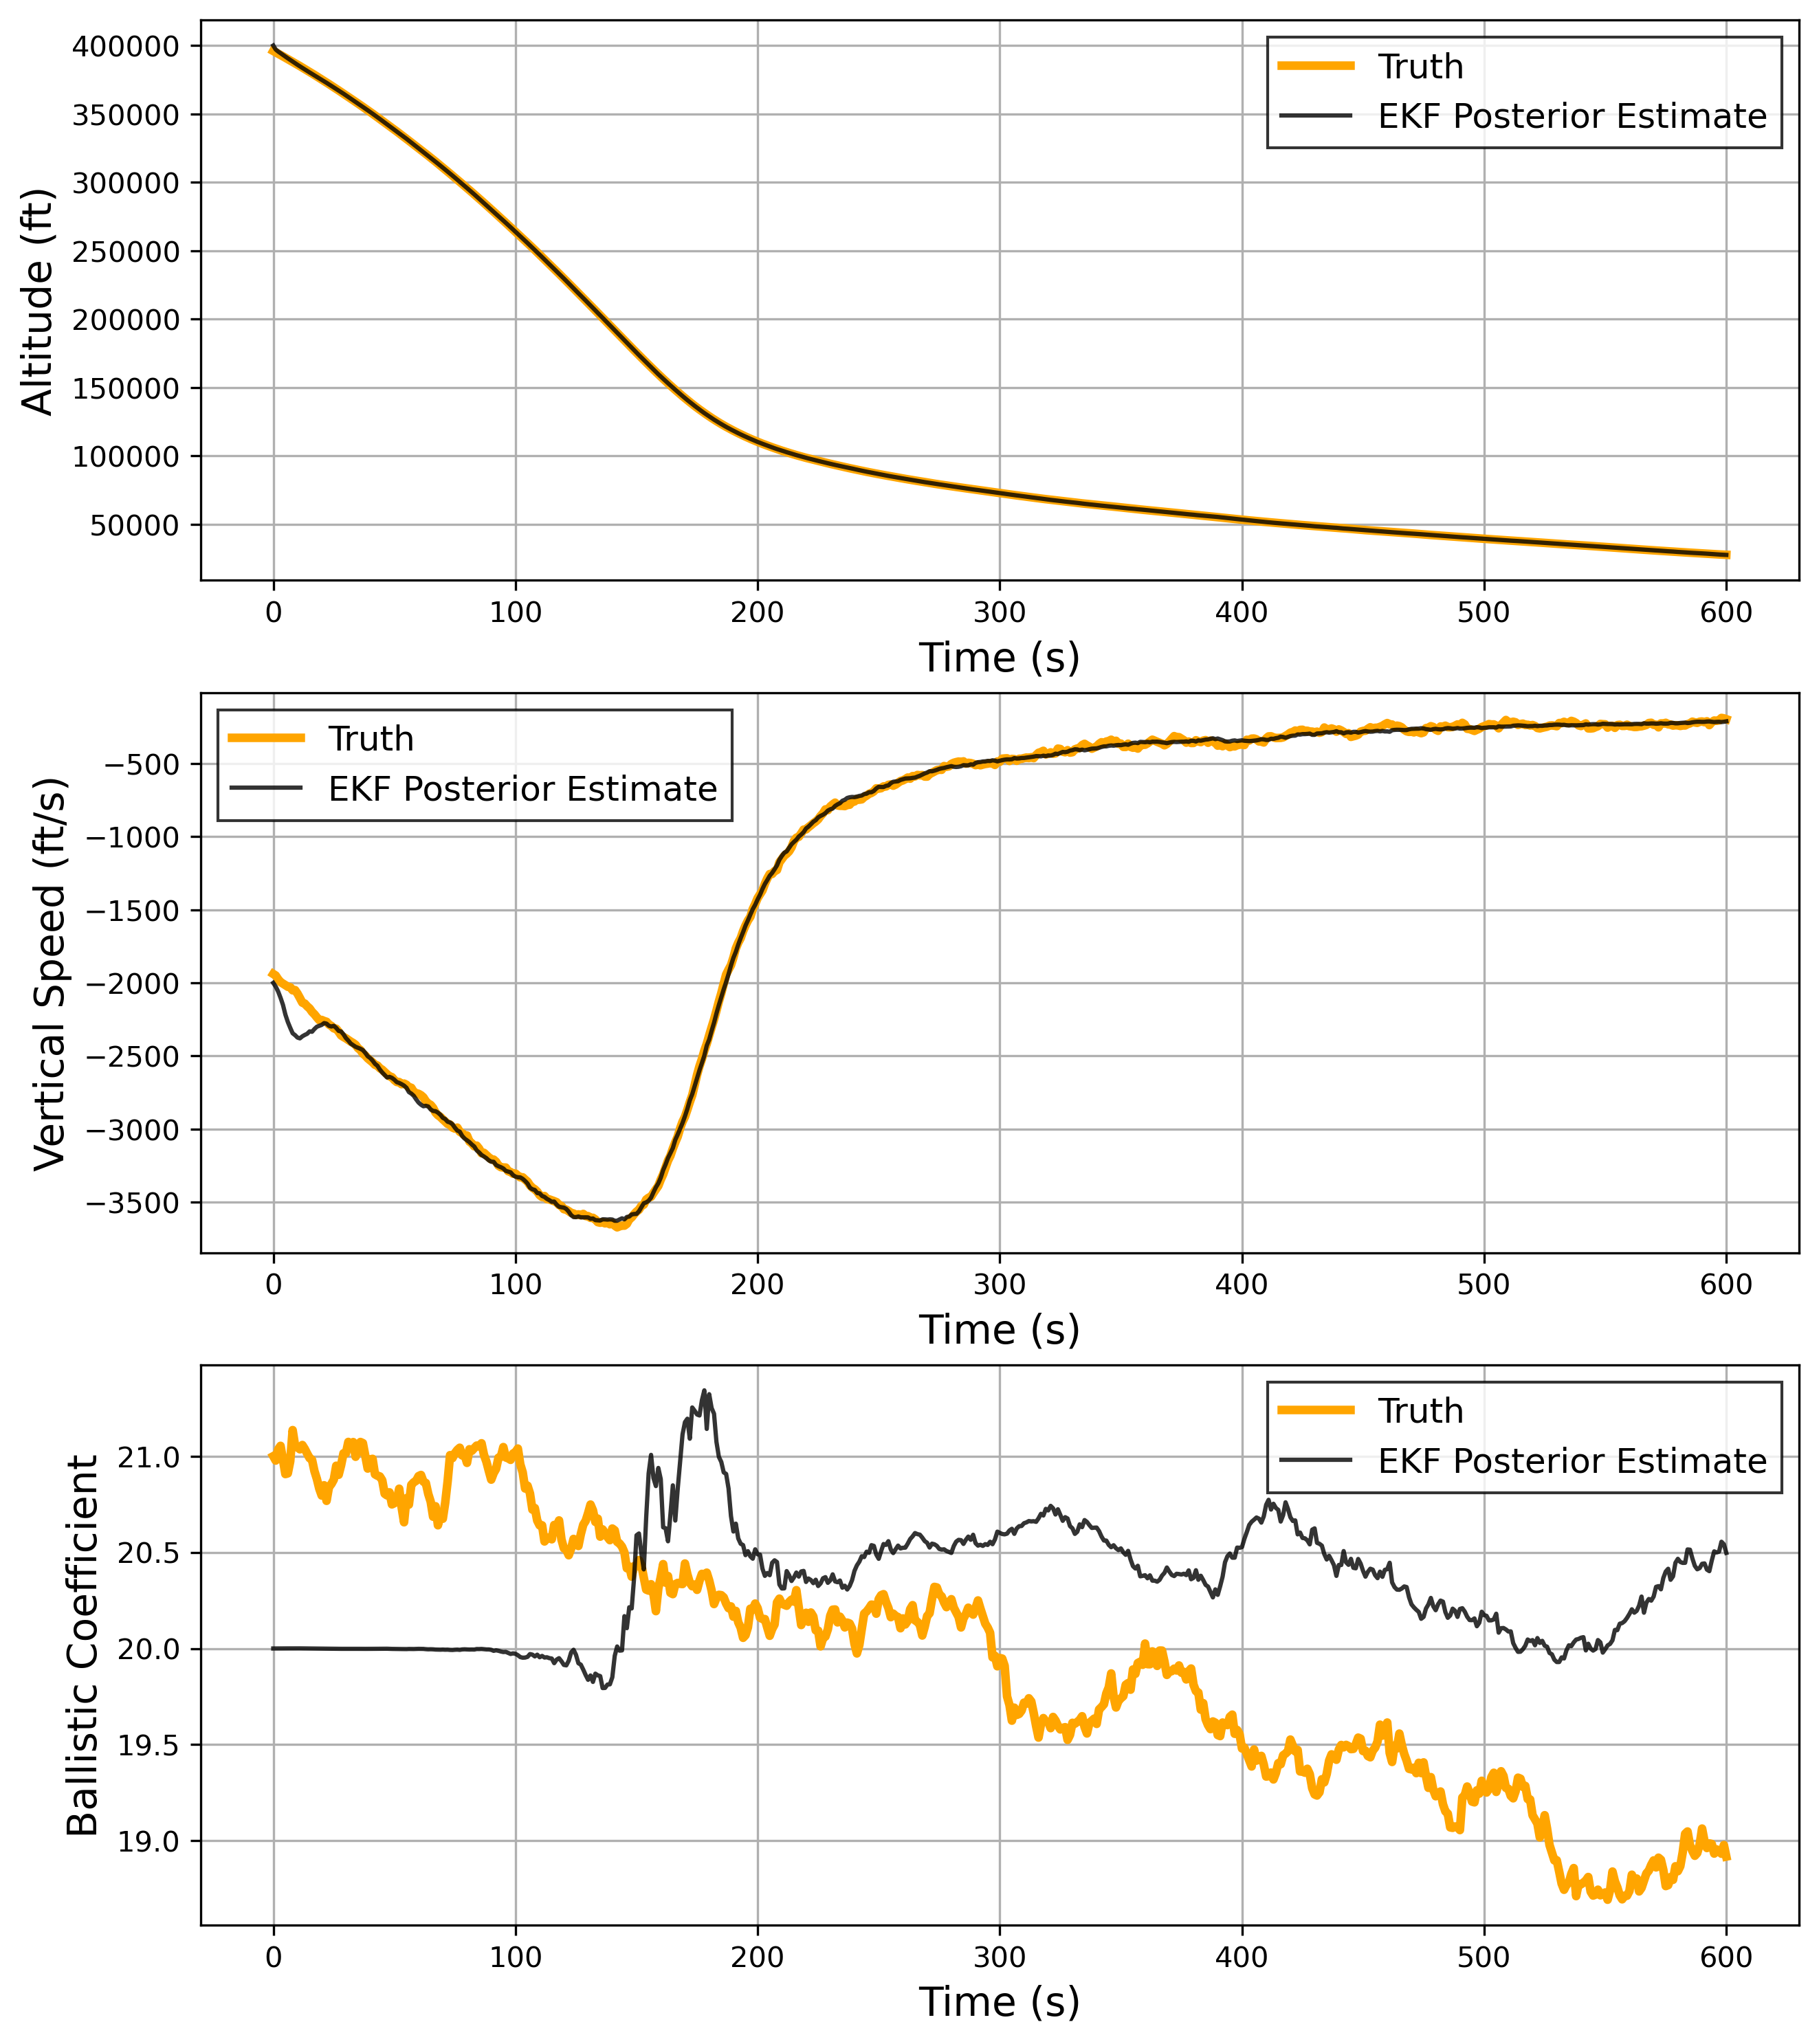

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(
    dpi=300, figsize=(10, 12), nrows=3, ncols=1, sharex=False
)
ax1.plot(df["hk"], c="orange", linestyle="-", lw=3, label="Truth")
ax1.plot(res[:, 0], c="black", linestyle="-", alpha=0.8, label="EKF Posterior Estimate")
ax1.grid()
leg = ax1.legend(fancybox=False, fontsize=12)
ax1.set_xlabel("Time (s)", fontsize=14)
ax1.set_ylabel("Altitude (ft)", fontsize=14)

ax2.plot(df["sk"], c="orange", linestyle="-", lw=3, label="Truth")
ax2.plot(res[:, 1], c="black", linestyle="-", alpha=0.8, label="EKF Posterior Estimate")
ax2.grid()
leg = ax2.legend(fancybox=False, fontsize=12)
ax2.set_xlabel("Time (s)", fontsize=14)
ax2.set_ylabel("Vertical Speed (ft/s)", fontsize=14)

ax3.plot(df["cbk"], c="orange", linestyle="-", lw=3, label="Truth")
ax3.plot(res[:, 2], c="black", linestyle="-", alpha=0.8, label="EKF Posterior Estimate")
ax3.grid()
leg = ax3.legend(fancybox=False, fontsize=12)
ax3.set_xlabel("Time (s)", fontsize=14)
ax3.set_ylabel("Ballistic Coefficient", fontsize=14)
plt.show()

# B. Implement a sigma-point Kalman filter (SPKF), e.g., an unscented Kalman filter (UKF), to estimate the vehicle states, $h$ and $s$, and the ballistic coefficient parameter, $C_b$.

### Functions for Unscented Transform

In [11]:
def get_sigmas_weights(X, P, alpha=1e-3, beta=2, k=0):
    L = len(X)
    lamda = alpha**2 + (L + k) - L

    # Define arrays to hold sigma points and weights
    sigs, wc, wm = np.zeros((2 * L + 1, L)), np.zeros(2 * L + 1), np.zeros(2 * L + 1)

    # Get sigma points
    U = cholesky(
        (L + lamda) * P
    )  # L + lambda*P is a matrix, find its square root using cholesky decomposition
    sigs[0] = X
    for k in range(L):
        sigs[k + 1] = (
            sigs[0] + U[k]
        )  # for points i = 1 ... L choose positive side of mean
        sigs[L + k + 1] = (
            sigs[0] - U[k]
        )  # for points i = (L+1) ... 2*L choose negative side of mean

    # Get weights
    wm[0] = lamda / (L + lamda)
    wc[0] = (lamda / (L + lamda)) + (1 - alpha**2 + beta)
    for k in range(2 * L):
        wm[k + 1] = 1 / (2 * (L + lamda))
        wc[k + 1] = 1 / (2 * (L + lamda))
    return sigs, wm, wc

In [12]:
def ukf_predict(Xin, Pin, Qin, alpha=1e-3, beta=2, k=0):
    L = len(Xin)
    P_out = np.zeros(Pin.shape)

    # Compute sigma points and pass them through nonlinear state transition function
    sigmas, weights_mean, weights_covariance = get_sigmas_weights(Xin, Pin)
    transformed_points = propogate(sigmas.T).T

    # Compute weighted priori state mean with transformed sigma points
    x_k_km1 = np.dot(weights_mean, transformed_points)

    # Compute weighted state covariance prior
    for i, sigpt in enumerate(transformed_points):
        diff = (sigpt - x_k_km1).reshape(3, 1)
        P_out += weights_covariance[i] * np.dot(diff, diff.T)
    P_k_km1 = P_out + Q

    return x_k_km1, P_k_km1, weights_mean, weights_covariance, transformed_points

In [13]:
def ukf_update(Xin, Pin, Rin, measurement_in, sigmas_in, weights_mean, weights_cov):
    # Define constants and matrices to hold covariances
    L = len(Xin)
    Pz = np.zeros(Rin.shape)  # Measurement covariance
    Pxz = np.zeros((1, 3))  # State-measurement cross covariance

    # Pass sigma points through measurement function and compute weighted mean
    Z = get_measurement(sigmas_in.T)
    mu_z = np.dot(weights_mean, Z)

    # Compute measurement covariance, innovation, and state/meas cross covariance
    for k, predicted_meausurement in enumerate(Z):
        diff = predicted_meausurement - mu_z
        Pz += weights_cov[k] * np.dot(diff, diff.T)
    Pz += Rin
    y = measurement_in - mu_z

    for i, sig_point in enumerate(sigmas_in):
        d1 = sig_point - Xin
        d2 = (Z[i] - mu_z).T
        Pxz += weights_cov[i] * np.dot(d1, d2)

    # Compute kalman gain and form posterior state and covariance
    K = (Pxz / Pz).flatten()
    x_k_k = (Xin + np.dot(K, y)).flatten()
    P_k_k = Pin - np.outer(K * Pz, K.T)
    return x_k_k, P_k_k

### Run Filter on Measurements

In [14]:
n = len(df["yk"]) - 1
measurements_vector = df["yk"].to_numpy()
ukf_res = np.zeros((n, 3))
for k in range(n):
    if k == 0:
        x = x0
        P = P0
        ukf_res[k] = x
        continue
    x_k_k1, P_k_k1, wm, wc, spts = ukf_predict(x, P, Q)
    x_k_k, P_k_k = ukf_update(x_k_k1, P_k_k1, R, measurements_vector[k], spts, wm, wc)
    x = x_k_k
    P = P_k_k
    ukf_res[k] = x

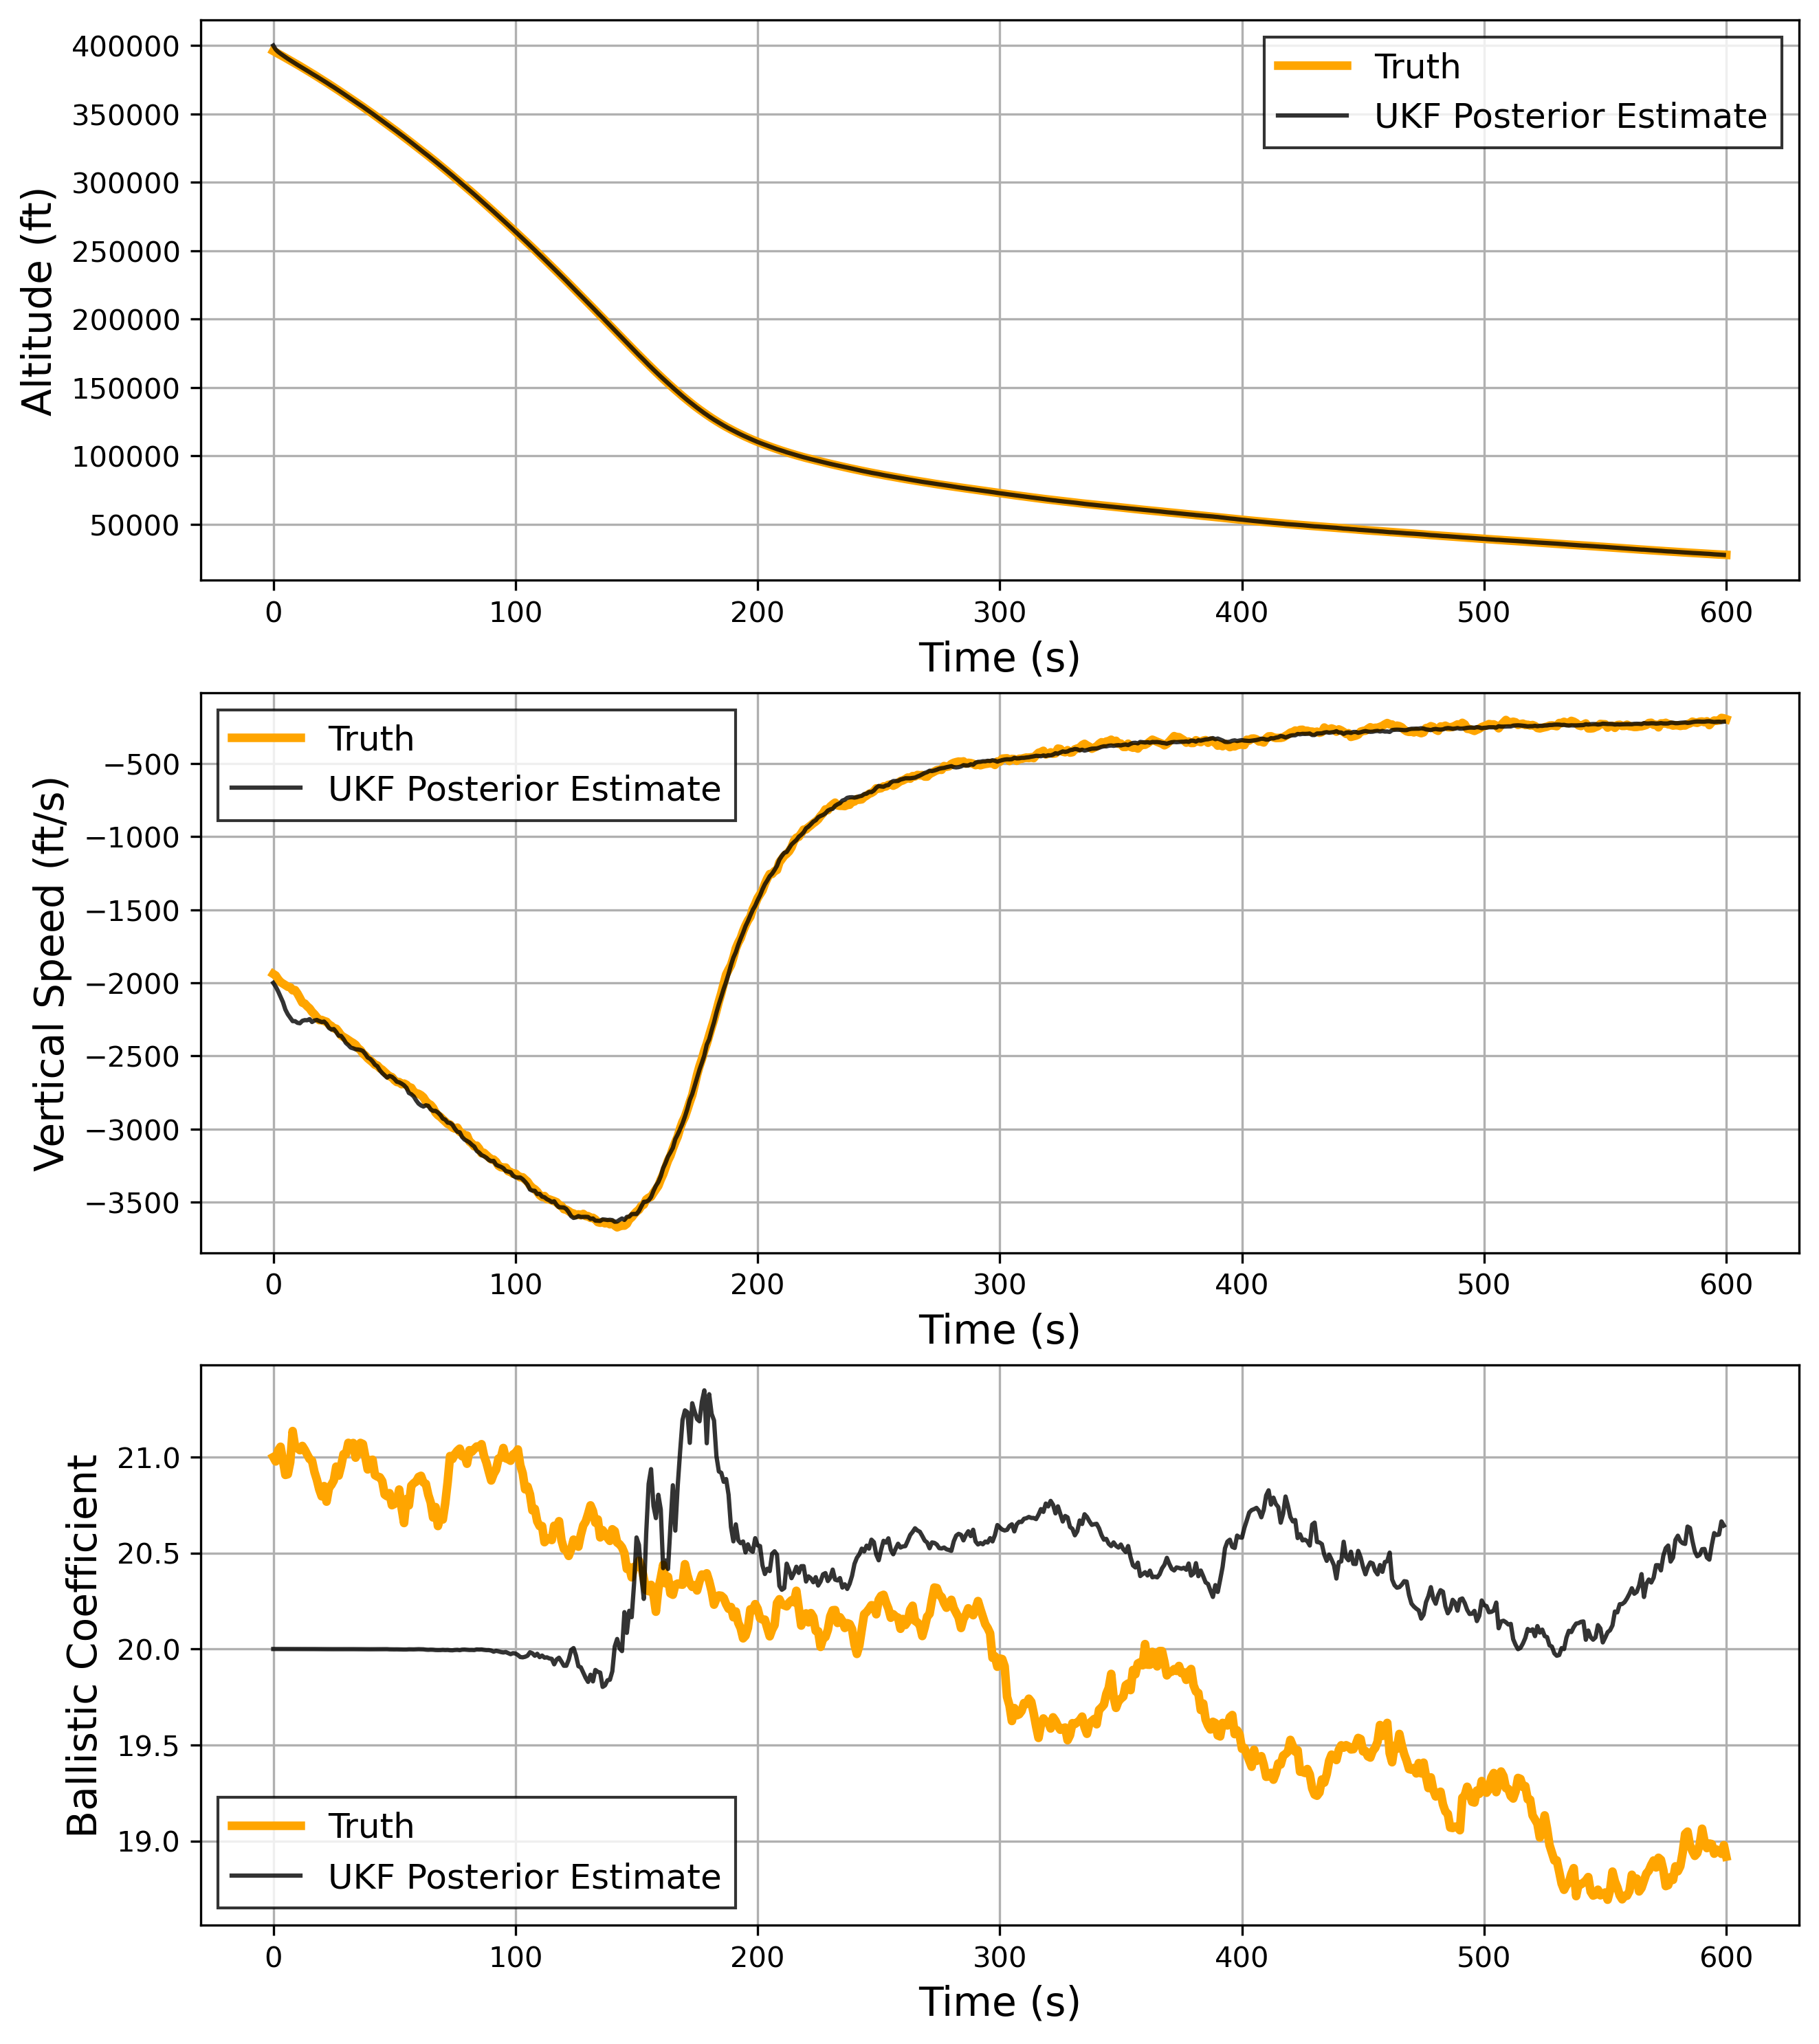

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(
    dpi=300, figsize=(10, 12), nrows=3, ncols=1, sharex=False
)
ax1.plot(df["hk"], c="orange", linestyle="-", lw=3, label="Truth")
ax1.plot(
    ukf_res[:, 0], c="black", linestyle="-", alpha=0.8, label="UKF Posterior Estimate"
)
ax1.grid()
leg = ax1.legend(fancybox=False, fontsize=12)
ax1.set_xlabel("Time (s)", fontsize=14)
ax1.set_ylabel("Altitude (ft)", fontsize=14)

ax2.plot(df["sk"], c="orange", linestyle="-", lw=3, label="Truth")
ax2.plot(
    ukf_res[:, 1], c="black", linestyle="-", alpha=0.8, label="UKF Posterior Estimate"
)
ax2.grid()
leg = ax2.legend(fancybox=False, fontsize=12)
ax2.set_xlabel("Time (s)", fontsize=14)
ax2.set_ylabel("Vertical Speed (ft/s)", fontsize=14)

ax3.plot(df["cbk"], c="orange", linestyle="-", lw=3, label="Truth")
ax3.plot(
    ukf_res[:, 2], c="black", linestyle="-", alpha=0.8, label="UKF Posterior Estimate"
)
ax3.grid()
leg = ax3.legend(fancybox=False, fontsize=12)
ax3.set_xlabel("Time (s)", fontsize=14)
ax3.set_ylabel("Ballistic Coefficient", fontsize=14)
plt.show()
fig.savefig("UKF.png")

# C. Implement a bootstrap particle filter (BPF) to estimate the vehicle states $h$, and $s$, and the ballistic coefficient parameter, $C_b$.

In [16]:
def get_particles(x0, nparticles):
    """Assign particles to uniform distribution bounded by the initial estimate, and the negative of the initial estimate"""
    weights = np.ones(nparticles) / nparticles
    particles = np.zeros((nparticles, 3))
    particles[:, 0] = np.random.uniform(-x0[0], x0[0], size=nparticles)
    particles[:, 1] = np.random.uniform(-x0[1], x0[1], size=nparticles)
    particles[:, 2] = np.random.uniform(-x0[2], x0[2], size=nparticles)
    return particles, weights


# def get_particles(x0, nparticles):
#     '''Assign particles to uniform distribution bounded by the initial estimate, and the negative of the initial estimate'''
#     weights = np.ones(nparticles) / nparticles
#     particles = np.random.multivariate_normal(mean=x0, cov=Q,size=nparticles)
#     return particles, weights


def bpf_predict(particles, Q):
    """Propogate particles and add Gaussian noise"""
    propogated_particles = propogate(particles.T)
    # Add Gaussian noise to each particle's state to capture uncertainty in process
    Qh, Qv, Qc = np.diag(Q)
    noises_h = np.random.randn(len(particles)) * Qh
    noises_v = np.random.randn(len(particles)) * Qv
    noises_c = np.random.randn(len(particles)) * Qc
    noises = np.vstack((noises_h, noises_v, noises_c))
    propogated_particles_noised = propogated_particles + noises
    return propogated_particles_noised.T


def bpf_update(particles, weights, z, R):
    for k, particle in enumerate(particles):
        h_state = particle[0]
        likelihood = norm(z, R).pdf(h_state)
        weights[k] *= likelihood
    weights /= np.sum(weights)
    return weights


def simple_resample(particles, weights):
    """NOTE:
    Function borrowed from Roger Labbe's Kalman Filter book, Chapter 12"""
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.0  # avoid round-off error
    rng = np.random.default_rng()
    indexes = np.searchsorted(cumulative_sum, rng.random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    return particles, weights


def estimate_state(particles, weights):
    mu = np.average(particles, weights=weights, axis=0)
    sigma = np.average((particles - mu) ** 2, weights=weights, axis=0)
    return mu, sigma

In [17]:
N = 100
pf_res = np.zeros((n, 3))
for k, measurement in enumerate(measurements_vector):
    if k == 0:
        particles, weights = get_particles(x0, N)
        pf_res[k] = x0
        continue
    prod_particles = bpf_predict(particles, Q)
    weights_update = bpf_update(prod_particles, weights, measurement, R)
    resampled_particles, resampled_weights = simple_resample(
        prod_particles, weights_update
    )
    estimate_mean, estimate_variance = estimate_state(
        resampled_particles, resampled_weights
    )
    particles = resampled_particles
    weights = resampled_weights
    pf_res[k - 1] = estimate_mean

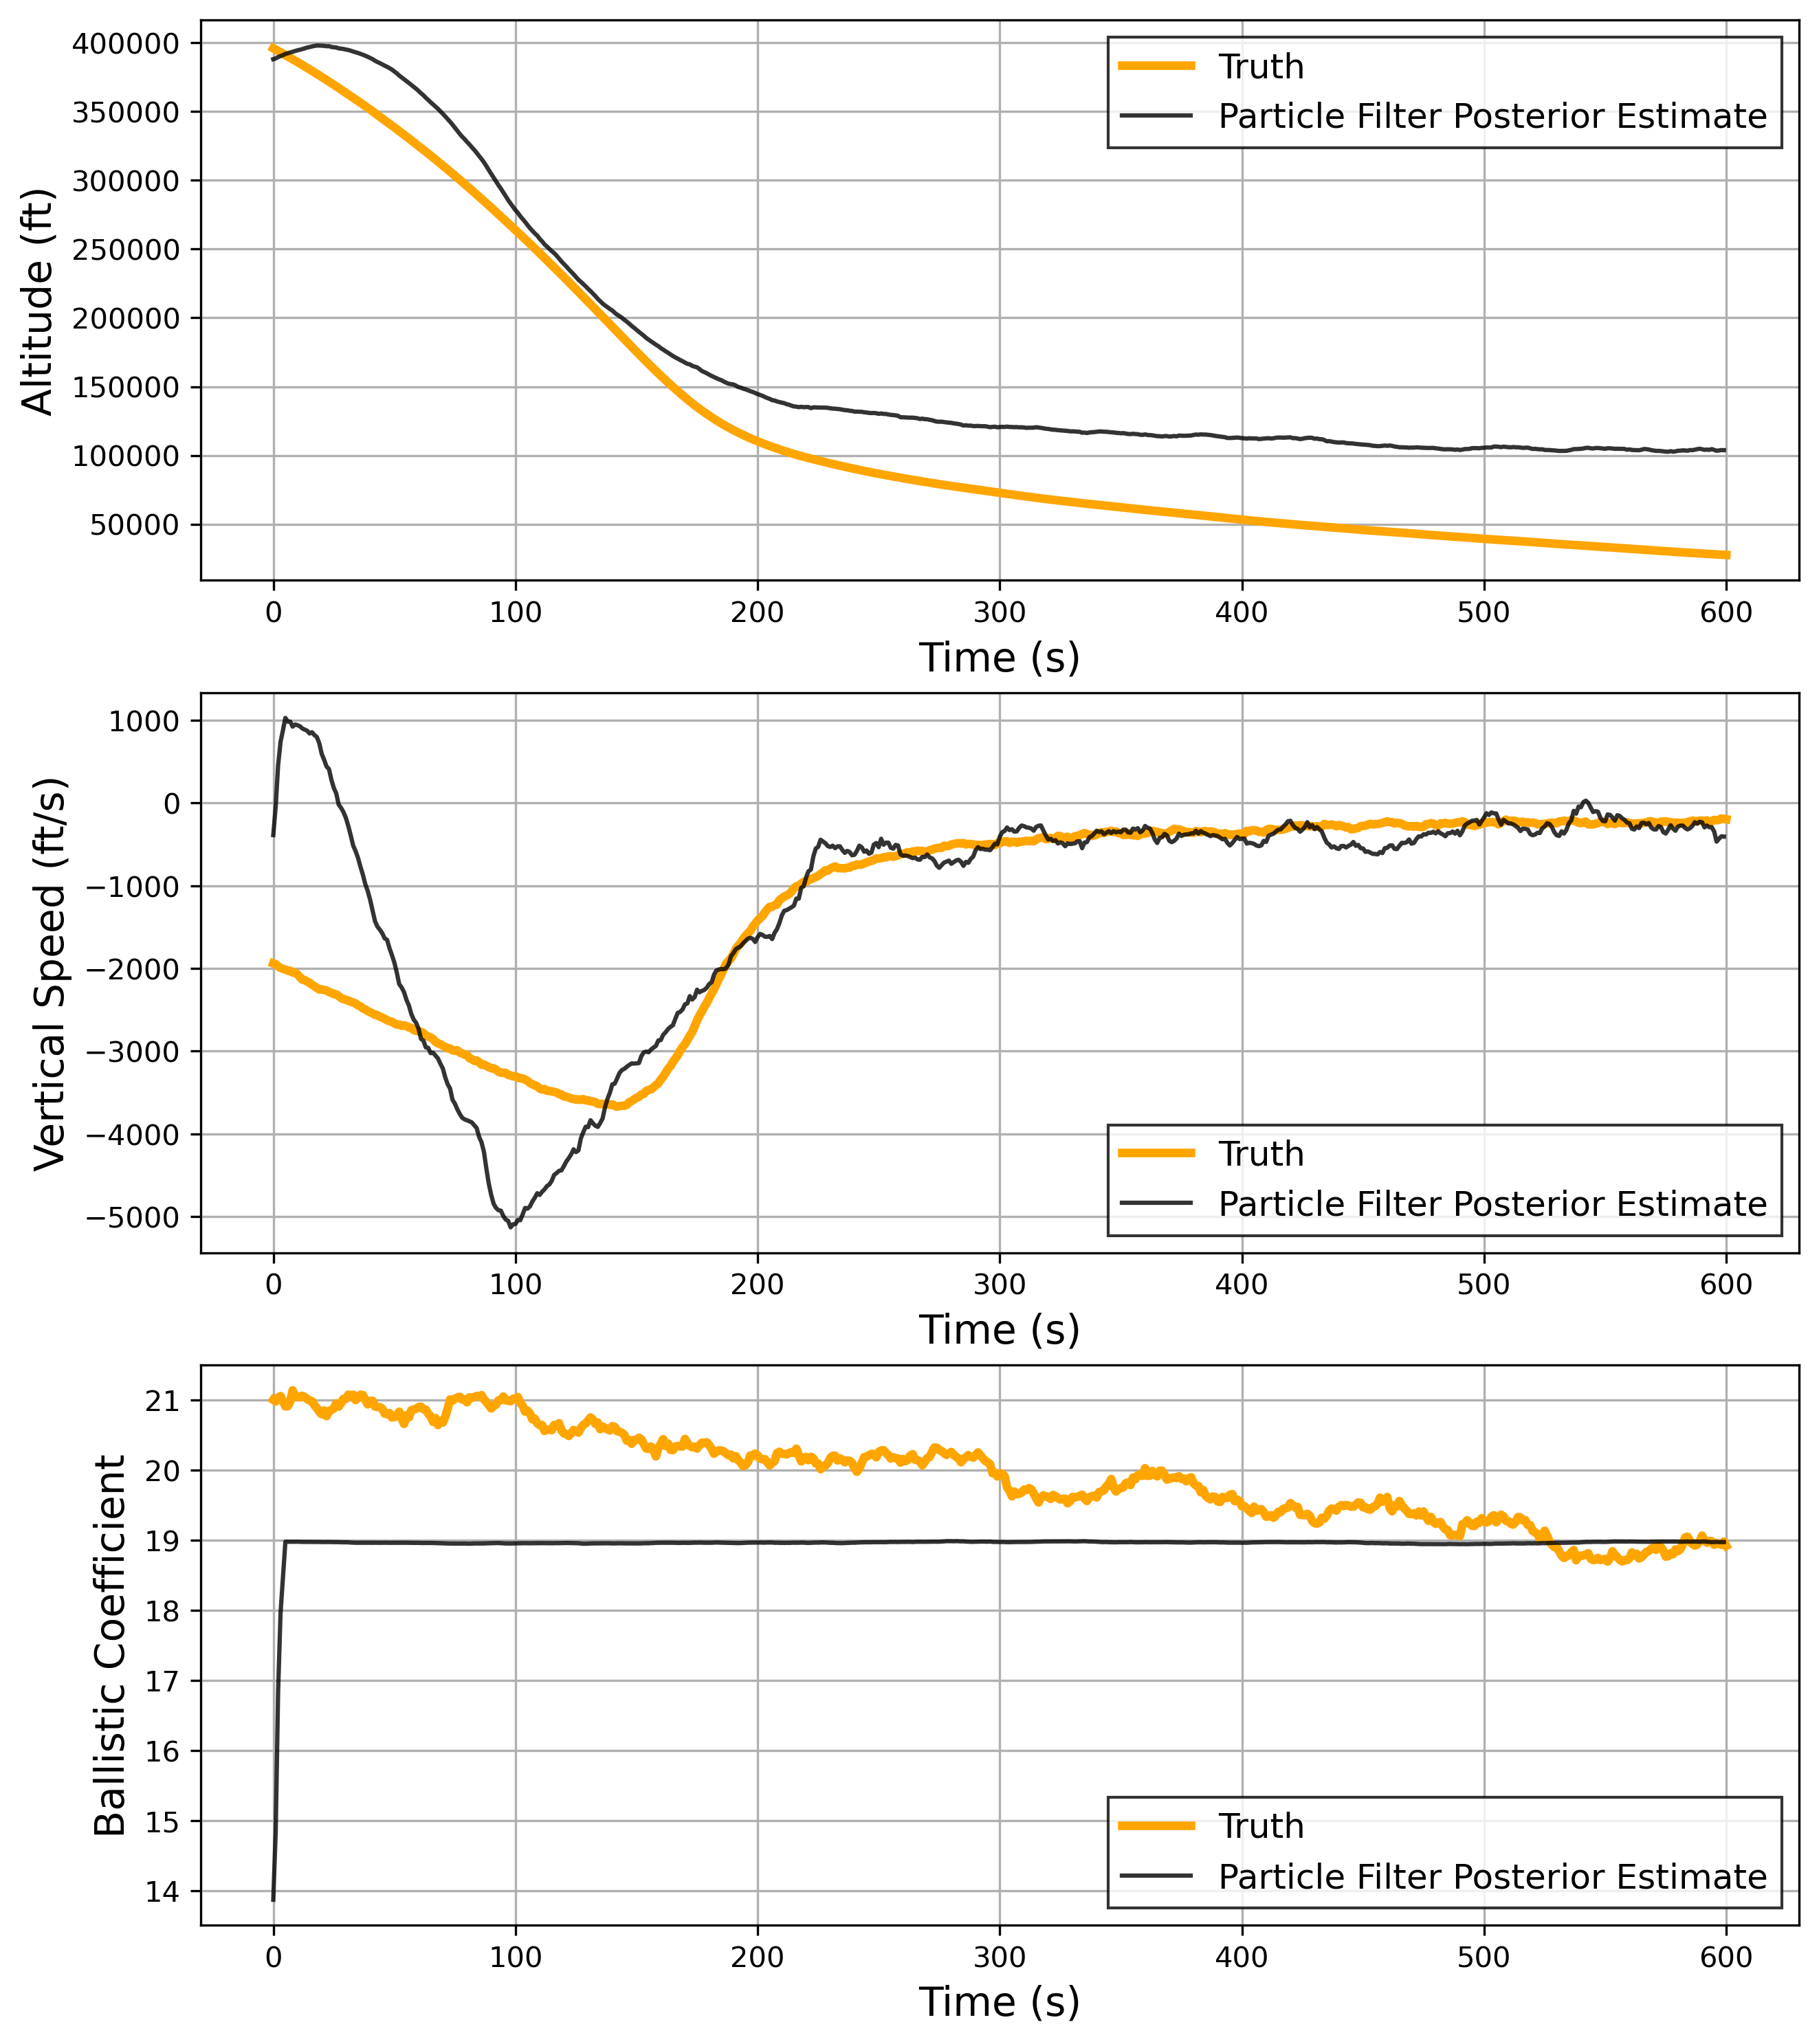

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(
    dpi=300, figsize=(10, 12), nrows=3, ncols=1, sharex=False
)
ax1.plot(df["hk"], c="orange", linestyle="-", lw=3, label="Truth")
ax1.plot(
    pf_res[:, 0],
    c="black",
    linestyle="-",
    alpha=0.8,
    label="Particle Filter Posterior Estimate",
)
ax1.grid()
leg = ax1.legend(fancybox=False, fontsize=12)
ax1.set_xlabel("Time (s)", fontsize=14)
ax1.set_ylabel("Altitude (ft)", fontsize=14)

ax2.plot(df["sk"], c="orange", linestyle="-", lw=3, label="Truth")
ax2.plot(
    pf_res[:, 1],
    c="black",
    linestyle="-",
    alpha=0.8,
    label="Particle Filter Posterior Estimate",
)
ax2.grid()
leg = ax2.legend(fancybox=False, fontsize=12)
ax2.set_xlabel("Time (s)", fontsize=14)
ax2.set_ylabel("Vertical Speed (ft/s)", fontsize=14)

ax3.plot(df["cbk"], c="orange", linestyle="-", lw=3, label="Truth")
ax3.plot(
    pf_res[:, 2],
    c="black",
    linestyle="-",
    alpha=0.8,
    label="Particle Filter Posterior Estimate",
)
ax3.grid()
leg = ax3.legend(fancybox=False, fontsize=12)
ax3.set_xlabel("Time (s)", fontsize=14)
ax3.set_ylabel("Ballistic Coefficient", fontsize=14)
plt.show()

# D. Comment on the accuracy and computational costs of each method.

> **Accuracy**: 
> - The UKF and EKF provided a more accurate state estimate than the BPF. I believe this is due to the lack of particles in my filter. The runtime as I wrote it becomes way too long after 100-200 particles. I suspect this would aid the accuracy. 
> - In terms of the relative accuracy, the EKF and UKF were on par. From the state estimates, it appears that the UKF converged more quickly on the altitude and velocity states than the EKF.

> **Computational Cost**: 
> - For every iteration of the EKF, it propogated the state, computed the analytical Jacobian, and substituted in state values to get a predicted estimate. This is done using a symbolic toolbox and I'd guess is very expensive. Whereas the UKF used a handful of sigma points to estimate the probability distribution for each time step, a relatively cheap computation.  
> - The BPF is obviously the most computationally-intensive as it takes a Monte Carlo approach, aka 'Brute Force'. With fewer particles, it becomes as cheap as the UKF but is significantly less accurate due to its sampling approach. 

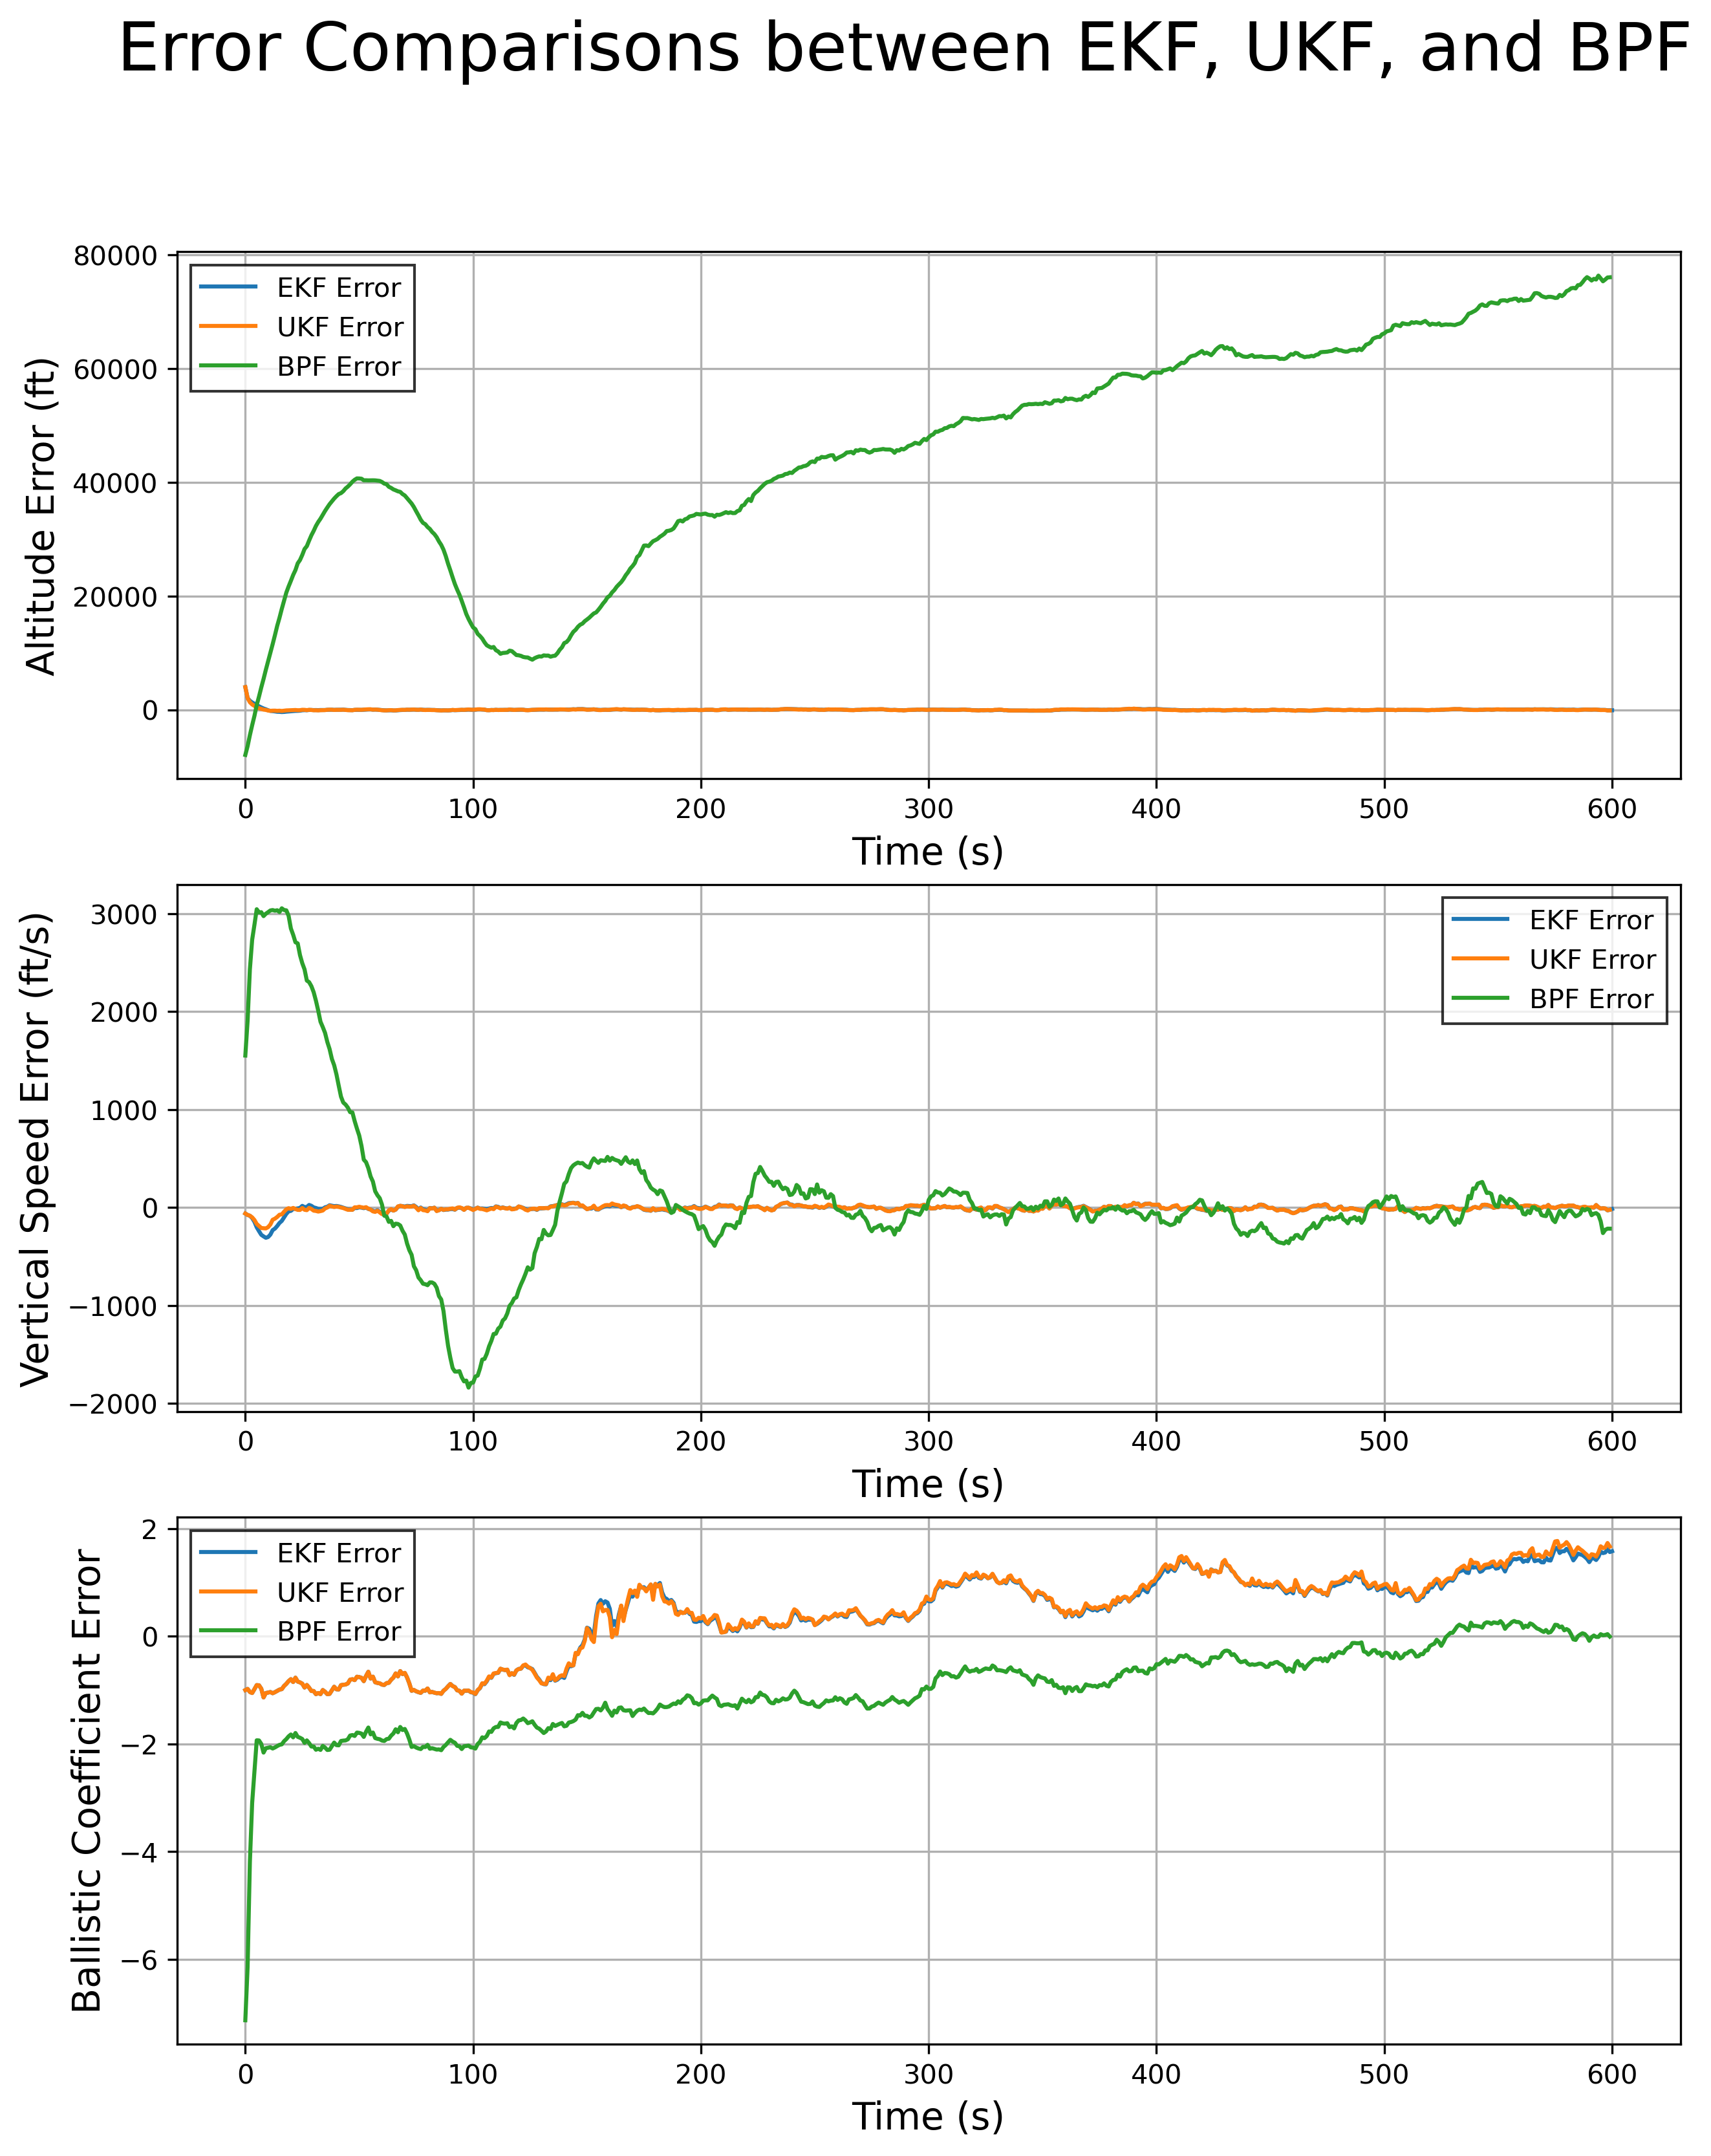

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(
    dpi=300, figsize=(10, 12), nrows=3, ncols=1, sharex=False
)
fig.suptitle("Error Comparisons between EKF, UKF, and BPF", fontsize=25)
ax1.plot(res[:, 0] - df["hk"], label="EKF Error")
ax1.plot(ukf_res[:, 0] - df["hk"][:-1], label="UKF Error")
ax1.plot(pf_res[:, 0] - df["hk"][:-1], label="BPF Error")
ax1.legend(fancybox=False)
ax1.set_xlabel("Time (s)", fontsize=14)
ax1.set_ylabel("Altitude Error (ft)", fontsize=14)

ax1.grid()
ax2.plot(res[:, 1] - df["sk"], label="EKF Error")
ax2.plot(ukf_res[:, 1] - df["sk"][:-1], label="UKF Error")
ax2.plot(pf_res[:, 1] - df["sk"][:-1], label="BPF Error")
ax2.legend(fancybox=False)
ax2.grid()
ax2.set_xlabel("Time (s)", fontsize=14)
ax2.set_ylabel("Vertical Speed Error (ft/s)", fontsize=14)

ax3.plot(res[:, 2] - df["cbk"], label="EKF Error")
ax3.plot(ukf_res[:, 2] - df["cbk"][:-1], label="UKF Error")
ax3.plot(pf_res[:, 2] - df["cbk"][:-1], label="BPF Error")
ax3.set_xlabel("Time (s)", fontsize=14)
ax3.set_ylabel("Ballistic Coefficient Error", fontsize=14)
ax3.legend(fancybox=False)
ax3.grid()